### Capture des chiffres dans les décalques afin de créér le dataset dimage pour construire le model de reconaissance de chiffre 

🚀 EXTRACTION ET SAUVEGARDE DES RÉGIONS D'INTÉRÊT

📋 Option 1: Affichage + Sauvegarde
ROI  1: Position(2060,3366) Taille(248×355) → Extrait(248×355)
ROI  2: Position(2358,3344) Taille(259×315) → Extrait(259×315)
ROI  3: Position(2617,3282) Taille(265×309) → Extrait(265×309)
ROI  4: Position(2820,3152) Taille(304×265) → Extrait(304×265)
ROI  5: Position(2967,2944) Taille(343×287) → Extrait(343×287)
ROI  6: Position(3220,2679) Taille(298×316) → Extrait(298×316)
ROI  7: Position(3316,2409) Taille(292×327) → Extrait(292×327)
ROI  8: Position(3361,2184) Taille(337×225) → Extrait(337×225)
ROI  9: Position(3349,1942) Taille(361×191) → Extrait(361×191)
ROI 10: Position(3316,1610) Taille(343×304) → Extrait(343×304)
ROI 11: Position(3265,1317) Taille(304×338) → Extrait(304×338)
ROI 12: Position(3085,1069) Taille(332×349) → Extrait(332×349)
ROI 13: Position(2854, 867) Taille(355×360) → Extrait(355×360)
ROI 14: Position(2662, 686) Taille(305×372) → Extrait(305×372)
ROI 15: Position(2409, 641) Taill

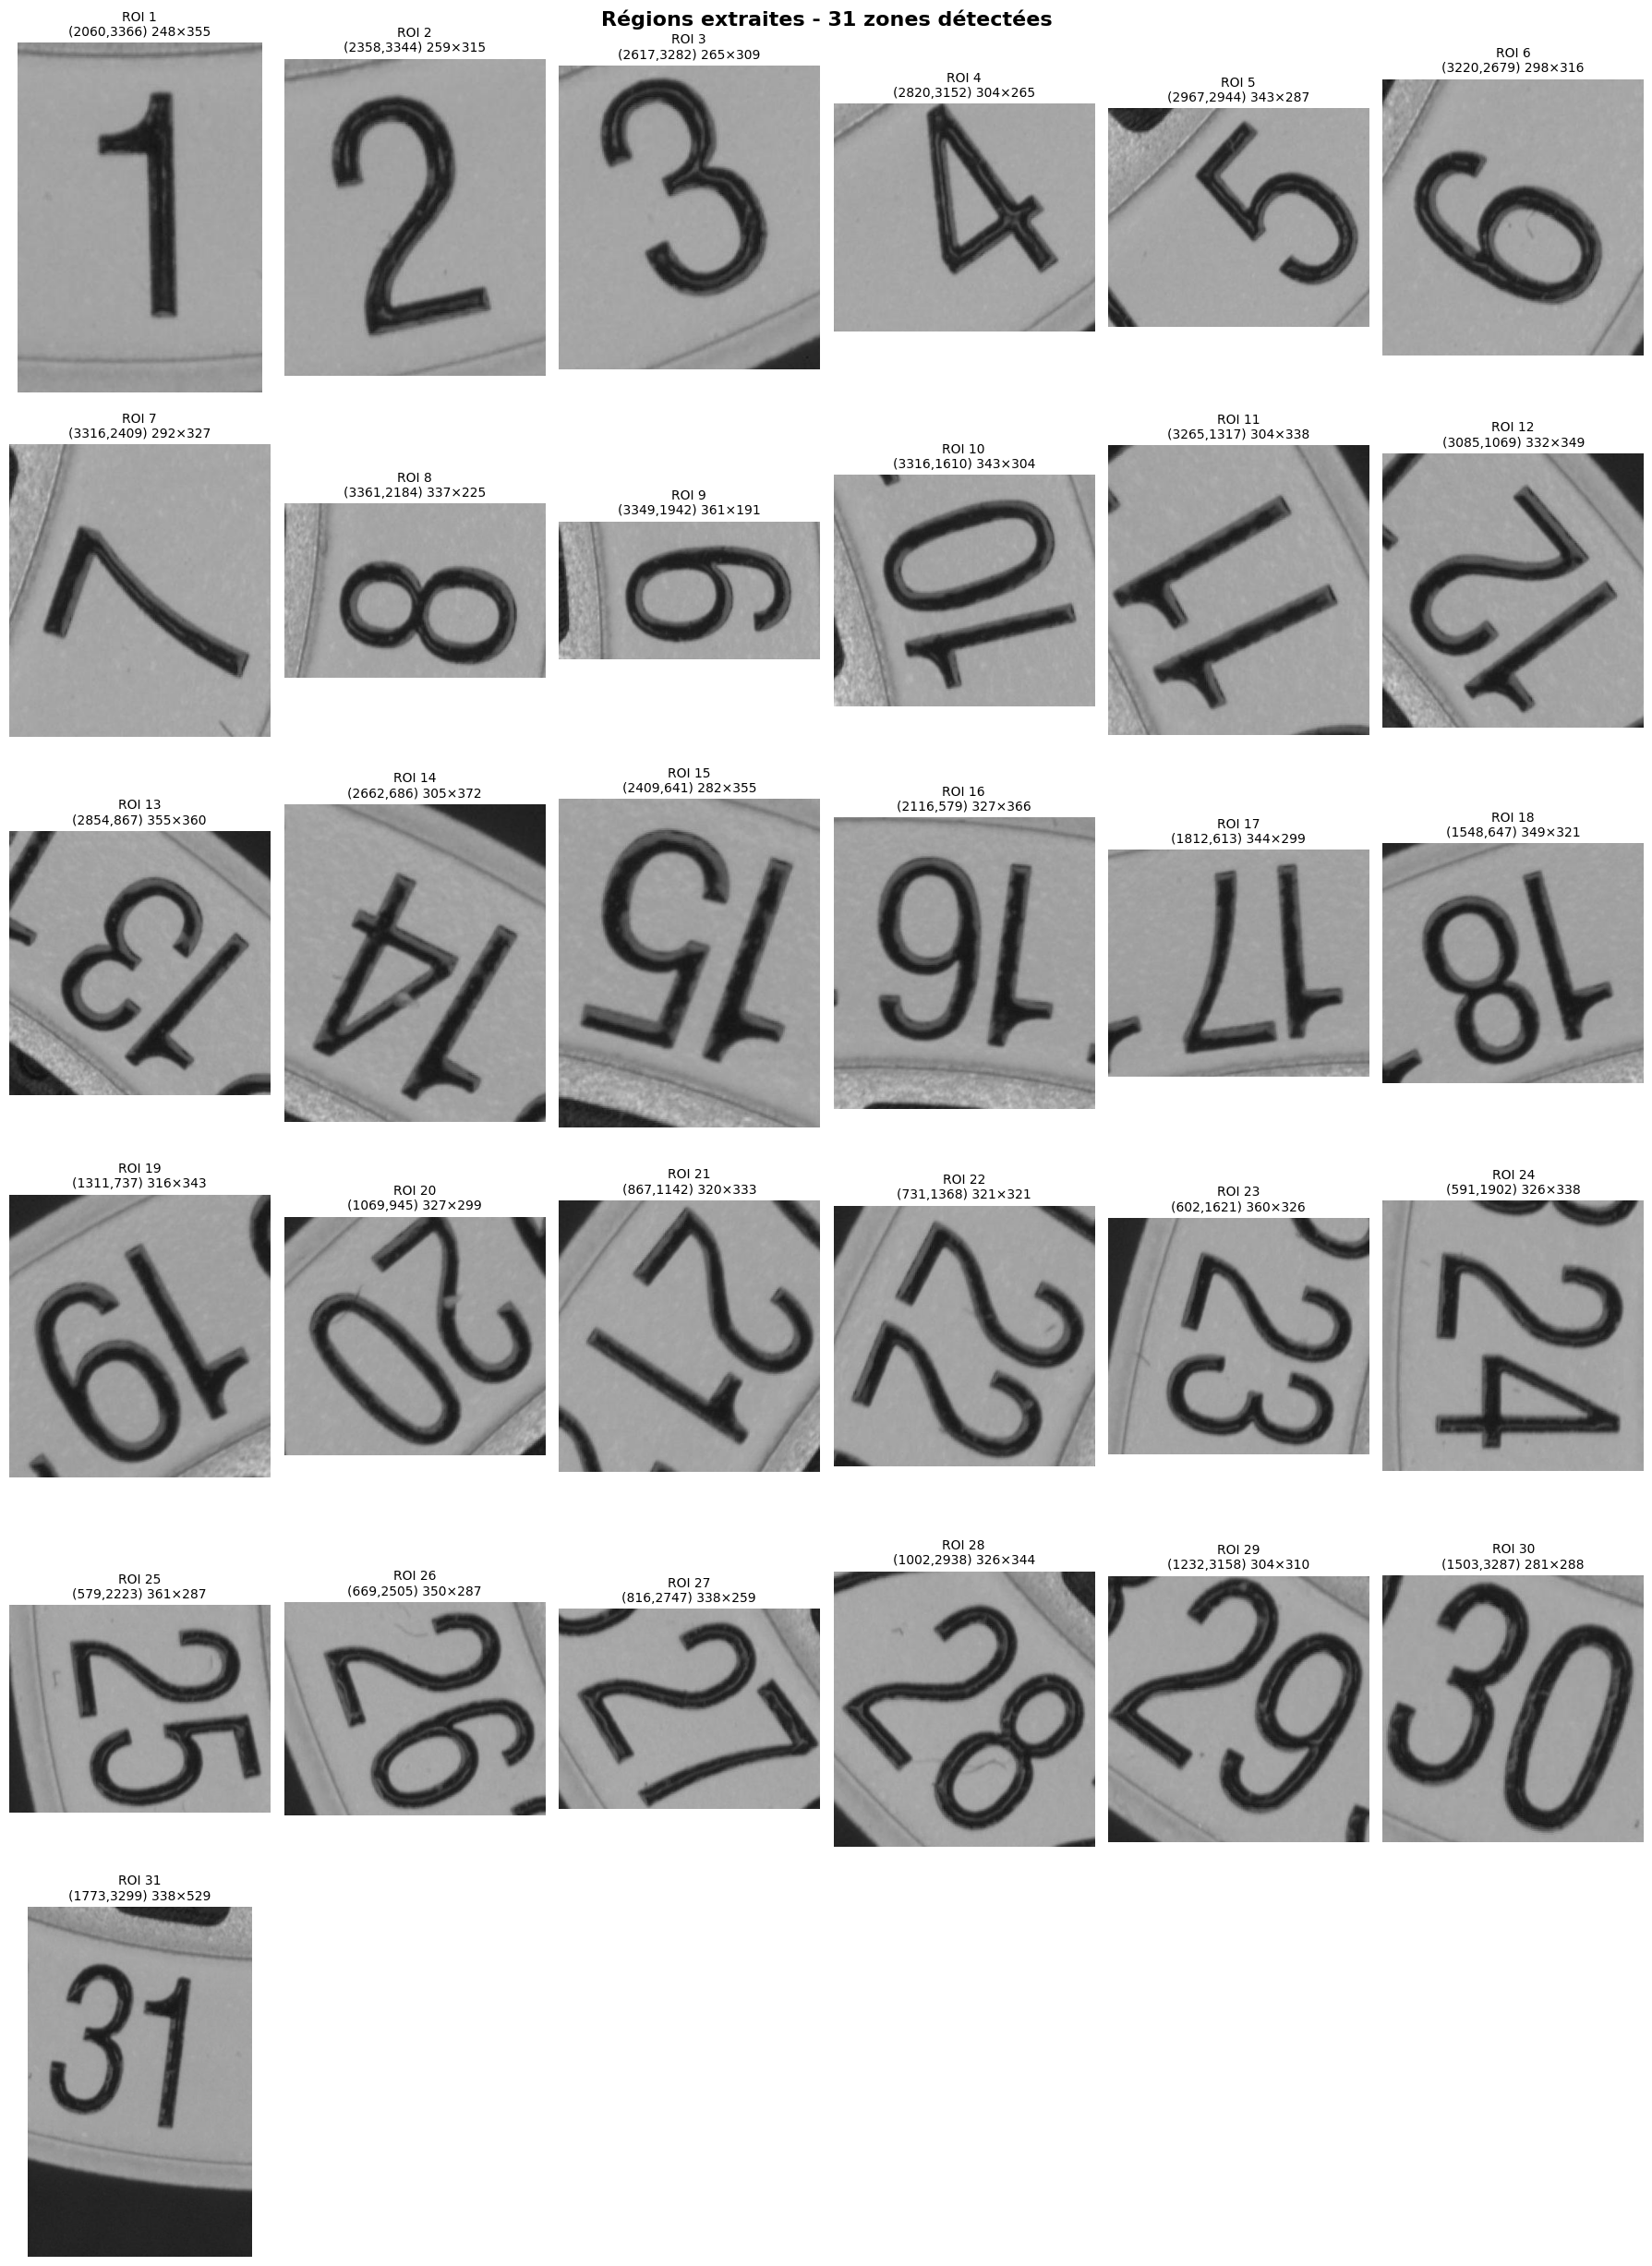

📁 Dossier 'extracted_rois' créé
💾 Sauvegarde des ROIs dans 'extracted_rois'...
✅ ROI  1: 30mm_BonW_7_roi_01_x2060_y3366_w248_h355.jpg (248×355 pixels)
✅ ROI  2: 30mm_BonW_7_roi_02_x2358_y3344_w259_h315.jpg (259×315 pixels)
✅ ROI  3: 30mm_BonW_7_roi_03_x2617_y3282_w265_h309.jpg (265×309 pixels)
✅ ROI  4: 30mm_BonW_7_roi_04_x2820_y3152_w304_h265.jpg (304×265 pixels)
✅ ROI  5: 30mm_BonW_7_roi_05_x2967_y2944_w343_h287.jpg (343×287 pixels)
✅ ROI  6: 30mm_BonW_7_roi_06_x3220_y2679_w298_h316.jpg (298×316 pixels)
✅ ROI  7: 30mm_BonW_7_roi_07_x3316_y2409_w292_h327.jpg (292×327 pixels)
✅ ROI  8: 30mm_BonW_7_roi_08_x3361_y2184_w337_h225.jpg (337×225 pixels)
✅ ROI  9: 30mm_BonW_7_roi_09_x3349_y1942_w361_h191.jpg (361×191 pixels)
✅ ROI 10: 30mm_BonW_7_roi_10_x3316_y1610_w343_h304.jpg (343×304 pixels)
✅ ROI 11: 30mm_BonW_7_roi_11_x3265_y1317_w304_h338.jpg (304×338 pixels)
✅ ROI 12: 30mm_BonW_7_roi_12_x3085_y1069_w332_h349.jpg (332×349 pixels)
✅ ROI 13: 30mm_BonW_7_roi_13_x2854_y867_w355_h360.jpg (35

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def extract_and_display_regions(rectangles, image_path, cols=5, figsize=(15, 20)):
    """
    Extrait et affiche les régions d'intérêt à partir d'une liste de rectangles
    
    Parameters:
    - rectangles: Liste de dictionnaires avec les clés 'x', 'y', 'width', 'height'
    - image_path: Chemin vers l'image source
    - cols: Nombre de colonnes pour l'affichage (défaut: 5)
    - figsize: Taille de la figure matplotlib (défaut: (15, 20))
    """
    
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: Impossible de charger l'image '{image_path}'")
        return
    
    # Convertir BGR vers RGB pour matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculer le nombre de lignes nécessaires
    rows = (len(rectangles) + cols - 1) // cols
    
    # Crée la figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(f'Régions extraites - {len(rectangles)} zones détectées', fontsize=16, fontweight='bold')
    
    # S'assurer que axes est toujours un tableau 2D
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Extraire et afficher chaque région
    for i, rect in enumerate(rectangles):
        row = i // cols
        col = i % cols
        
        # Extraire la région
        x, y, w, h = rect['x'], rect['y'], rect['width'], rect['height']
        
        # Vérifier les limites de l'image
        x = max(0, x)
        y = max(0, y)
        x_end = min(image_rgb.shape[1], x + w)
        y_end = min(image_rgb.shape[0], y + h)
        
        # Extraire la région d'intérêt
        roi = image_rgb[y:y_end, x:x_end]
        
        # Afficher la région
        ax = axes[row, col]
        ax.imshow(roi)
        ax.set_title(f'ROI {i+1}\n({x},{y}) {w}×{h}', fontsize=10)
        ax.axis('off')
        
        # Afficher les dimensions de la région extraite
        print(f"ROI {i+1:2d}: Position({x:4d},{y:4d}) Taille({w:3d}×{h:3d}) → Extrait({roi.shape[1]:3d}×{roi.shape[0]:3d})")
    
    # Masquer les axes inutilisés
    total_plots = rows * cols
    for i in range(len(rectangles), total_plots):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def save_extracted_rois(rectangles, image_path, output_folder="extracted_rois"):
    """
    Extrait les régions d'intérêt et les sauvegarde dans un dossier
    
    Parameters:
    - rectangles: Liste de dictionnaires avec les clés 'x', 'y', 'width', 'height'
    - image_path: Chemin vers l'image source
    - output_folder: Nom du dossier de sortie (défaut: "extracted_rois")
    
    Returns:
    - Liste des chemins des fichiers sauvegardés
    """
    
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: Impossible de charger l'image '{image_path}'")
        return []
    
    # Créer le dossier de sortie s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"📁 Dossier '{output_folder}' créé")
    
    # Extraire le nom de base de l'image pour le naming
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    saved_files = []
    
    print(f"💾 Sauvegarde des ROIs dans '{output_folder}'...")
    
    # Extraire et sauvegarder chaque région
    for i, rect in enumerate(rectangles):
        x, y, w, h = rect['x'], rect['y'], rect['width'], rect['height']
        
        # Vérifier les limites de l'image
        x = max(0, x)
        y = max(0, y)
        x_end = min(image.shape[1], x + w)
        y_end = min(image.shape[0], y + h)
        
        # Extraire la région d'intérêt
        roi = image[y:y_end, x:x_end]
        
        # Créer le nom du fichier
        filename = f"{base_name}_roi_{i+1:02d}_x{x}_y{y}_w{w}_h{h}.jpg"
        filepath = os.path.join(output_folder, filename)
        
        # Sauvegarder l'image
        success = cv2.imwrite(filepath, roi)
        
        if success:
            saved_files.append(filepath)
            print(f"✅ ROI {i+1:2d}: {filename} ({roi.shape[1]}×{roi.shape[0]} pixels)")
        else:
            print(f"❌ Erreur lors de la sauvegarde de ROI {i+1}")
    
    print(f"\n🎉 {len(saved_files)}/{len(rectangles)} ROIs sauvegardées avec succès!")
    print(f"📂 Dossier: {os.path.abspath(output_folder)}")
    
    return saved_files

def extract_display_and_save(rectangles, image_path, output_folder="extracted_rois", cols=5, figsize=(15, 20)):
    """
    Fonction combinée qui affiche ET sauvegarde les ROIs
    
    Parameters:
    - rectangles: Liste de dictionnaires avec les clés 'x', 'y', 'width', 'height'
    - image_path: Chemin vers l'image source
    - output_folder: Nom du dossier de sortie (défaut: "extracted_rois")
    - cols: Nombre de colonnes pour l'affichage (défaut: 5)
    - figsize: Taille de la figure matplotlib (défaut: (15, 20))
    
    Returns:
    - Tuple (figure_matplotlib, liste_fichiers_sauvegardés)
    """
    
    # Afficher les ROIs
    fig = extract_and_display_regions(rectangles, image_path, cols, figsize)
    
    # Sauvegarder les ROIs
    saved_files = save_extracted_rois(rectangles, image_path, output_folder)
    
    return fig, saved_files

def extract_regions_as_array(rectangles, image_path):
    """
    Extrait les régions et les retourne comme un tableau numpy
    
    Returns:
    - Liste des régions extraites (images numpy)
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: Impossible de charger l'image '{image_path}'")
        return []
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    regions = []
    
    for i, rect in enumerate(rectangles):
        x, y, w, h = rect['x'], rect['y'], rect['width'], rect['height']
        
        # Vérifier les limites
        x = max(0, x)
        y = max(0, y)
        x_end = min(image_rgb.shape[1], x + w)
        y_end = min(image_rgb.shape[0], y + h)
        
        # Extraire la région
        roi = image_rgb[y:y_end, x:x_end]
        regions.append(roi)
    
    return regions

# ============================================================================
# EXEMPLE D'UTILISATION COMPLET
# ============================================================================

if __name__ == "__main__":
    
    # Vos rectangles détectés
    rectangles = [
        {'x': 2060, 'y': 3366, 'width': 248, 'height': 355},
        {'x': 2358, 'y': 3344, 'width': 259, 'height': 315},
        {'x': 2617, 'y': 3282, 'width': 265, 'height': 309},
        {'x': 2820, 'y': 3152, 'width': 304, 'height': 265},
        {'x': 2967, 'y': 2944, 'width': 343, 'height': 287},
        {'x': 3220, 'y': 2679, 'width': 298, 'height': 316},
        {'x': 3316, 'y': 2409, 'width': 292, 'height': 327},
        {'x': 3361, 'y': 2184, 'width': 337, 'height': 225},
        {'x': 3349, 'y': 1942, 'width': 361, 'height': 191},
        {'x': 3316, 'y': 1610, 'width': 343, 'height': 304},
        {'x': 3265, 'y': 1317, 'width': 304, 'height': 338},
        {'x': 3085, 'y': 1069, 'width': 332, 'height': 349},
        {'x': 2854, 'y': 867, 'width': 355, 'height': 360},
        {'x': 2662, 'y': 686, 'width': 305, 'height': 372},
        {'x': 2409, 'y': 641, 'width': 282, 'height': 355},
        {'x': 2116, 'y': 579, 'width': 327, 'height': 366},
        {'x': 1812, 'y': 613, 'width': 344, 'height': 299},
        {'x': 1548, 'y': 647, 'width': 349, 'height': 321},
        {'x': 1311, 'y': 737, 'width': 316, 'height': 343},
        {'x': 1069, 'y': 945, 'width': 327, 'height': 299},
        {'x': 867, 'y': 1142, 'width': 320, 'height': 333},
        {'x': 731, 'y': 1368, 'width': 321, 'height': 321},
        {'x': 602, 'y': 1621, 'width': 360, 'height': 326},
        {'x': 591, 'y': 1902, 'width': 326, 'height': 338},
        {'x': 579, 'y': 2223, 'width': 361, 'height': 287},
        {'x': 669, 'y': 2505, 'width': 350, 'height': 287},
        {'x': 816, 'y': 2747, 'width': 338, 'height': 259},
        {'x': 1002, 'y': 2938, 'width': 326, 'height': 344},
        {'x': 1232, 'y': 3158, 'width': 304, 'height': 310},
        {'x': 1503, 'y': 3287, 'width': 281, 'height': 288},
        {'x': 1773, 'y': 3299, 'width': 338, 'height': 529}
    ]
    
    # Chemin vers votre image 30mm_BonW_7.jpg
    image_path = "data/clean_image/30mm_BonW_7.jpg"  
    
    print("="*60)
    print("🚀 EXTRACTION ET SAUVEGARDE DES RÉGIONS D'INTÉRÊT")
    print("="*60)
    
    
    print("\n📋 Option 1: Affichage + Sauvegarde")
    fig, saved_files = extract_display_and_save(
        rectangles, 
        image_path, 
        output_folder="extracted_rois", 
        cols=6, 
        figsize=(18, 25)
    )
    
    
    print("\n📋 Option 2: Sauvegarde uniquement")
    saved_files = save_extracted_rois(rectangles, image_path, "extracted_rois")
    
    
    
    print("\n" + "="*60)
    print("✨ TRAITEMENT TERMINÉ !")
    print("="*60)


### Data augmentation pour multiplier plusieur image

In [ ]:
import os
from PIL import Image

def duplicate_images(input_folder, output_folder, target_count=750):
    """
    Duplique chaque image target_count fois sans modification
    """
    # Créer le dossier de sortie s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for i in range(1, 32):
        image_name = f"image{i}"
        
        # Chercher l'image avec différentes extensions possibles
        image_path = None
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            test_path = os.path.join(input_folder, image_name + ext)
            if os.path.exists(test_path):
                image_path = test_path
                break
        
        if image_path is None:
            print(f"⚠️  Image {image_name} non trouvée dans {input_folder}")
            continue
        
        # Créer un sous-dossier pour chaque chiffre
        digit_folder = os.path.join(output_folder, f"digit_{i}")
        os.makedirs(digit_folder, exist_ok=True)
        
        # Charger l'image originale
        try:
            original_image = Image.open(image_path)
            print(f"📷 Traitement de l'image {i} ({original_image.size})")
        except Exception as e:
            print(f"❌ Erreur lors du chargement de {image_name}: {e}")
            continue
        
        # Dupliquer l'image target_count fois
        for j in range(target_count):
            output_path = os.path.join(digit_folder, f"{image_name}_{j+1:04d}.png")
            original_image.save(output_path)
        
        print(f"🎉 Terminé pour le chiffre {i}: {target_count} duplications")

def main():
    input_folder = "dataset"  # Dossier contenant les images originales
    output_folder = "dataset_augmented"  # Dossier de sortie
    target_count = 750  # Nombre d'images par chiffre

    print("🚀 Début de la duplication des images")
    print(f"📁 Dossier source: {input_folder}")
    print(f"📁 Dossier destination: {output_folder}")
    print(f"🎯 Objectif: {target_count} duplications par chiffre")
    print("-" * 50)

    if not os.path.exists(input_folder):
        print(f"❌ Le dossier {input_folder} n'existe pas!")
        return

    duplicate_images(input_folder, output_folder, target_count)

    print("-" * 50)
    print("✨ Duplication terminée!")

    # Statistiques finales
    total_images = 0
    for i in range(1, 32):
        digit_folder = os.path.join(output_folder, f"digit_{i}")
        if os.path.exists(digit_folder):
            count = len([f for f in os.listdir(digit_folder) if f.endswith('.png')])
            total_images += count
            print(f"📊 Chiffre {i}: {count} images")

    print(f"📈 Total: {total_images} images générées")

if __name__ == "__main__":
    main()


### Entrainement du model 

Found 18600 images belonging to 31 classes.
Found 4650 images belonging to 31 classes.
Epoch 1/6
1163/1163 [==============================] - 329s 280ms/step - loss: 0.4715 - accuracy: 0.8714 - val_loss: 0.2685 - val_accuracy: 0.9222
Epoch 2/6
1163/1163 [==============================] - 219s 188ms/step - loss: 0.0984 - accuracy: 0.9718 - val_loss: 0.0721 - val_accuracy: 0.9815
Epoch 3/6
1163/1163 [==============================] - 213s 183ms/step - loss: 0.1247 - accuracy: 0.9735 - val_loss: 7.8756 - val_accuracy: 0.5178
Epoch 4/6
1163/1163 [==============================] - 218s 187ms/step - loss: 0.0730 - accuracy: 0.9857 - val_loss: 1.0323 - val_accuracy: 0.8877
Epoch 5/6
1163/1163 [==============================] - 220s 189ms/step - loss: 0.0713 - accuracy: 0.9878 - val_loss: 0.0183 - val_accuracy: 0.9970
Epoch 6/6
1163/1163 [==============================] - 217s 186ms/step - loss: 0.0699 - accuracy: 0.9895 - val_loss: 0.0292 - val_accuracy: 0.9955


c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Modèle sauvegardé sous cnn_digits_model.h5


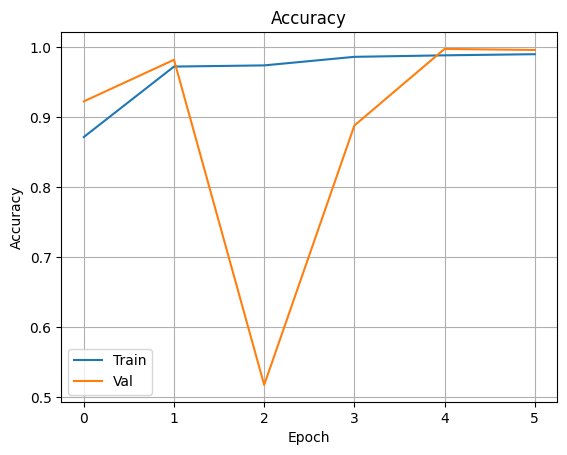

In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# Réglages
img_height = 64
img_width = 64
batch_size = 16
epochs = 6
dataset_dir = 'dataset_augmented'

# Chargement des données avec augmentation légère
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='rgb',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    shuffle=True
)

# Nombre de classes
num_classes = train_data.num_classes

# Modèle CNN simple
model = Sequential([
    # Bloc 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Bloc 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    # Bloc 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    # Dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data
)

# Sauvegarde
model.save('cnn_digits_model.h5')
print("✅ Modèle sauvegardé sous cnn_digits_model.h5")

# Affichage des courbes
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Test du model de lecture de chiffre 

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def extract_and_display_regions(rectangles, image_path, cols=5, figsize=(15, 20)):
    """
    Extrait et affiche les régions d'intérêt à partir d'une liste de rectangles
    
    Parameters:
    - rectangles: Liste de dictionnaires avec les clés 'x', 'y', 'width', 'height'
    - image_path: Chemin vers l'image source
    - cols: Nombre de colonnes pour l'affichage (défaut: 5)
    - figsize: Taille de la figure matplotlib (défaut: (15, 20))
    """
    
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: Impossible de charger l'image '{image_path}'")
        return
    
    # Convertir BGR vers RGB pour matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculer le nombre de lignes nécessaires
    rows = (len(rectangles) + cols - 1) // cols
    
    # Créer la figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(f'Régions extraites - {len(rectangles)} zones détectées', fontsize=16, fontweight='bold')
    
    # S'assurer que axes est toujours un tableau 2D
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Extraire et afficher chaque région
    for i, rect in enumerate(rectangles):
        row = i // cols
        col = i % cols
        
        # Extraire la région
        x, y, w, h = rect['x'], rect['y'], rect['width'], rect['height']
        
        # Vérifier les limites de l'image
        x = max(0, x)
        y = max(0, y)
        x_end = min(image_rgb.shape[1], x + w)
        y_end = min(image_rgb.shape[0], y + h)
        
        # Extraire la région d'intérêt
        roi = image_rgb[y:y_end, x:x_end]
        
        # Afficher la région
        ax = axes[row, col]
        ax.imshow(roi)
        ax.set_title(f'ROI {i+1}\n({x},{y}) {w}×{h}', fontsize=10)
        ax.axis('off')
        
        # Afficher les dimensions de la région extraite
        print(f"ROI {i+1:2d}: Position({x:4d},{y:4d}) Taille({w:3d}×{h:3d}) → Extrait({roi.shape[1]:3d}×{roi.shape[0]:3d})")
    
    # Masquer les axes inutilisés
    total_plots = rows * cols
    for i in range(len(rectangles), total_plots):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def save_extracted_rois(rectangles, image_path, output_folder="extracted_rois"):
    """
    Extrait les régions d'intérêt et les sauvegarde dans un dossier
    
    Parameters:
    - rectangles: Liste de dictionnaires avec les clés 'x', 'y', 'width', 'height'
    - image_path: Chemin vers l'image source
    - output_folder: Nom du dossier de sortie (défaut: "extracted_rois")
    
    Returns:
    - Liste des chemins des fichiers sauvegardés
    """
    
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: Impossible de charger l'image '{image_path}'")
        return []
    
    # Créer le dossier de sortie s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"📁 Dossier '{output_folder}' créé")
    
    # Extraire le nom de base de l'image pour le naming
    #base_name = os.path.splitext(os.path.basename(image_path))[0]
    base_name = "image"
    
    saved_files = []
    
    print(f"💾 Sauvegarde des ROIs dans '{output_folder}'...")
    
    # Extraire et sauvegarder chaque région
    for i, rect in enumerate(rectangles):
        x, y, w, h = rect['x'], rect['y'], rect['width'], rect['height']
        
        # Vérifier les limites de l'image
        x = max(0, x)
        y = max(0, y)
        x_end = min(image.shape[1], x + w)
        y_end = min(image.shape[0], y + h)
        
        # Extraire la région d'intérêt
        roi = image[y:y_end, x:x_end]
        
        # Créer le nom du fichier
        filename = f"{base_name}_roi_{i+1:02d}.jpg"
        filepath = os.path.join(output_folder, filename)
        
        # Sauvegarder l'image
        success = cv2.imwrite(filepath, roi)
        
        if success:
            saved_files.append(filepath)
            print(f"✅ ROI {i+1:2d}: {filename} ({roi.shape[1]}×{roi.shape[0]} pixels)")
        else:
            print(f"❌ Erreur lors de la sauvegarde de ROI {i+1}")
    
    print(f"\n🎉 {len(saved_files)}/{len(rectangles)} ROIs sauvegardées avec succès!")
    print(f"📂 Dossier: {os.path.abspath(output_folder)}")
    
    return saved_files

def extract_display_and_save(rectangles, image_path, output_folder="extracted_rois", cols=5, figsize=(15, 20)):
    """
    Fonction combinée qui affiche ET sauvegarde les ROIs
    
    Parameters:
    - rectangles: Liste de dictionnaires avec les clés 'x', 'y', 'width', 'height'
    - image_path: Chemin vers l'image source
    - output_folder: Nom du dossier de sortie (défaut: "extracted_rois")
    - cols: Nombre de colonnes pour l'affichage (défaut: 5)
    - figsize: Taille de la figure matplotlib (défaut: (15, 20))
    
    Returns:
    - Tuple (figure_matplotlib, liste_fichiers_sauvegardés)
    """
    
    # Afficher les ROIs
    #fig = extract_and_display_regions(rectangles, image_path, cols, figsize)
    
    # Sauvegarder les ROIs
    saved_files = save_extracted_rois(rectangles, image_path, output_folder)
    
    return saved_files

def extract_regions_as_array(rectangles, image_path):
    """
    Extrait les régions et les retourne comme un tableau numpy
    
    Returns:
    - Liste des régions extraites (images numpy)
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: Impossible de charger l'image '{image_path}'")
        return []
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    regions = []
    
    for i, rect in enumerate(rectangles):
        x, y, w, h = rect['x'], rect['y'], rect['width'], rect['height']
        
        # Vérifier les limites
        x = max(0, x)
        y = max(0, y)
        x_end = min(image_rgb.shape[1], x + w)
        y_end = min(image_rgb.shape[0], y + h)
        
        # Extraire la région
        roi = image_rgb[y:y_end, x:x_end]
        regions.append(roi)
    
    return regions

# ============================================================================
# EXEMPLE D'UTILISATION COMPLET
# ============================================================================

if __name__ == "__main__":
    
    # Vos rectangles détectés
    rectangles = [
        {'x': 2060, 'y': 3366, 'width': 248, 'height': 355},
        {'x': 2358, 'y': 3344, 'width': 259, 'height': 315},
        {'x': 2617, 'y': 3282, 'width': 265, 'height': 309},
        {'x': 2820, 'y': 3152, 'width': 304, 'height': 265},
        {'x': 2967, 'y': 2944, 'width': 343, 'height': 287},
        {'x': 3220, 'y': 2679, 'width': 298, 'height': 316},
        {'x': 3316, 'y': 2409, 'width': 292, 'height': 327},
        {'x': 3361, 'y': 2184, 'width': 337, 'height': 225},
        {'x': 3349, 'y': 1942, 'width': 361, 'height': 191},
        {'x': 3316, 'y': 1610, 'width': 343, 'height': 304},
        {'x': 3265, 'y': 1317, 'width': 304, 'height': 338},
        {'x': 3085, 'y': 1069, 'width': 332, 'height': 349},
        {'x': 2854, 'y': 867, 'width': 355, 'height': 360},
        {'x': 2662, 'y': 686, 'width': 305, 'height': 372},
        {'x': 2409, 'y': 641, 'width': 282, 'height': 355},
        {'x': 2116, 'y': 579, 'width': 327, 'height': 366},
        {'x': 1812, 'y': 613, 'width': 344, 'height': 299},
        {'x': 1548, 'y': 647, 'width': 349, 'height': 321},
        {'x': 1311, 'y': 737, 'width': 316, 'height': 343},
        {'x': 1069, 'y': 945, 'width': 327, 'height': 299},
        {'x': 867, 'y': 1142, 'width': 320, 'height': 333},
        {'x': 731, 'y': 1368, 'width': 321, 'height': 321},
        {'x': 602, 'y': 1621, 'width': 360, 'height': 326},
        {'x': 591, 'y': 1902, 'width': 326, 'height': 338},
        {'x': 579, 'y': 2223, 'width': 361, 'height': 287},
        {'x': 669, 'y': 2505, 'width': 350, 'height': 287},
        {'x': 816, 'y': 2747, 'width': 338, 'height': 259},
        {'x': 1002, 'y': 2938, 'width': 326, 'height': 344},
        {'x': 1232, 'y': 3158, 'width': 304, 'height': 310},
        {'x': 1503, 'y': 3287, 'width': 281, 'height': 288},
        {'x': 1773, 'y': 3299, 'width': 338, 'height': 529}
    ]
    
    # Chemin vers votre image 30mm_BonW_7.jpg
    image_path = "data/clean_image/30mm_BonW_9.jpg"  # Remplacez par le chemin de votre image
    
    print("="*60)
    print("🚀 EXTRACTION ET SAUVEGARDE DES RÉGIONS D'INTÉRÊT")
    print("="*60)
    
    # OPTION 1: Afficher ET sauvegarder (recommandé)
    print("\n📋 Option 1: Affichage + Sauvegarde")
    saved_files = extract_display_and_save(
        rectangles, 
        image_path, 
        output_folder="extracted_rois", 
        cols=6, 
        figsize=(18, 25)
    )
    
    

    
    
    print("\n" + "="*60)
    print("✨ TRAITEMENT TERMINÉ !")
    print("="*60)


🚀 EXTRACTION ET SAUVEGARDE DES RÉGIONS D'INTÉRÊT

📋 Option 1: Affichage + Sauvegarde
📁 Dossier 'extracted_rois' créé
💾 Sauvegarde des ROIs dans 'extracted_rois'...
✅ ROI  1: image_roi_01.jpg (248×355 pixels)
✅ ROI  2: image_roi_02.jpg (259×315 pixels)
✅ ROI  3: image_roi_03.jpg (265×309 pixels)
✅ ROI  4: image_roi_04.jpg (304×265 pixels)
✅ ROI  5: image_roi_05.jpg (343×287 pixels)
✅ ROI  6: image_roi_06.jpg (298×316 pixels)
✅ ROI  7: image_roi_07.jpg (292×327 pixels)
✅ ROI  8: image_roi_08.jpg (337×225 pixels)
✅ ROI  9: image_roi_09.jpg (361×191 pixels)
✅ ROI 10: image_roi_10.jpg (343×304 pixels)
✅ ROI 11: image_roi_11.jpg (304×338 pixels)
✅ ROI 12: image_roi_12.jpg (332×349 pixels)
✅ ROI 13: image_roi_13.jpg (355×360 pixels)
✅ ROI 14: image_roi_14.jpg (305×372 pixels)
✅ ROI 15: image_roi_15.jpg (282×355 pixels)
✅ ROI 16: image_roi_16.jpg (327×366 pixels)
✅ ROI 17: image_roi_17.jpg (344×299 pixels)
✅ ROI 18: image_roi_18.jpg (349×321 pixels)
✅ ROI 19: image_roi_19.jpg (316×343 pixels)


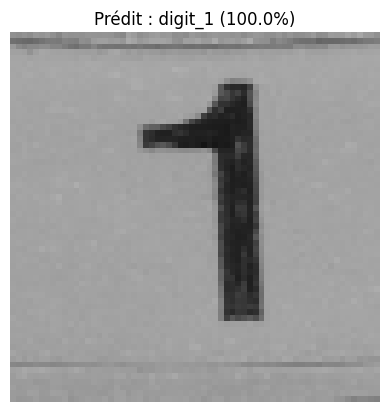

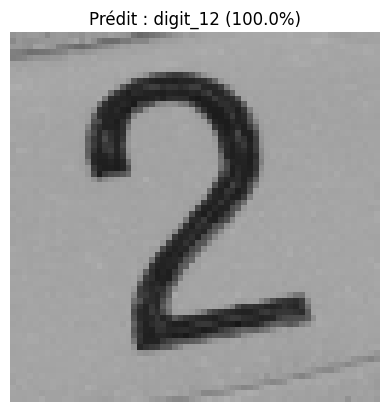

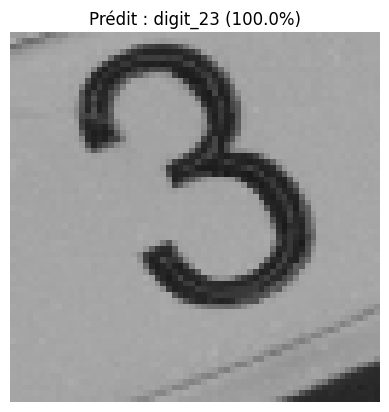

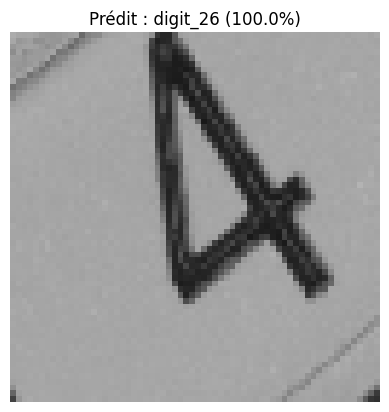

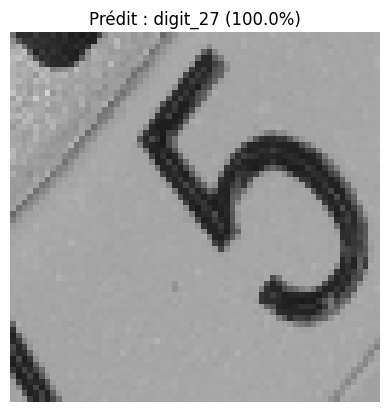

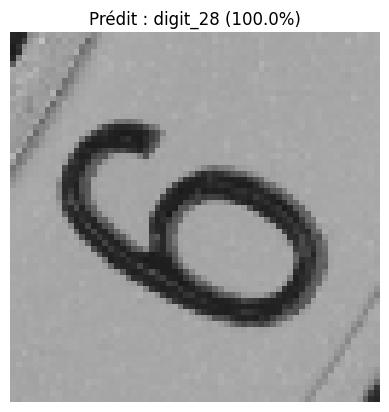

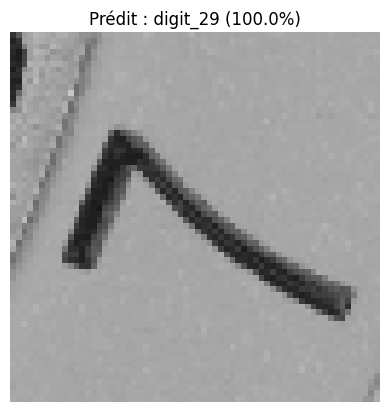

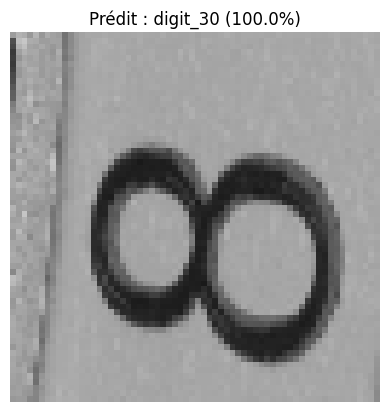

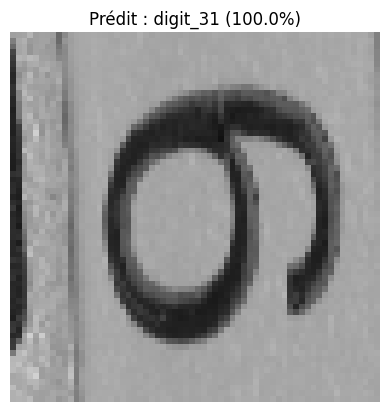

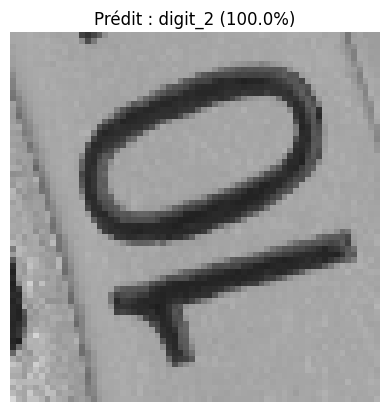

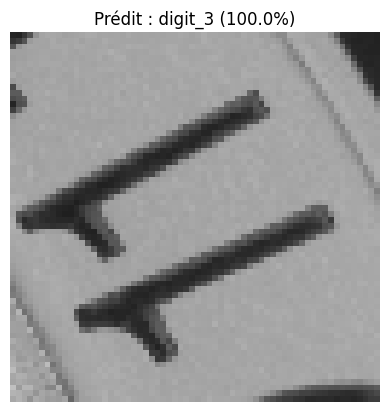

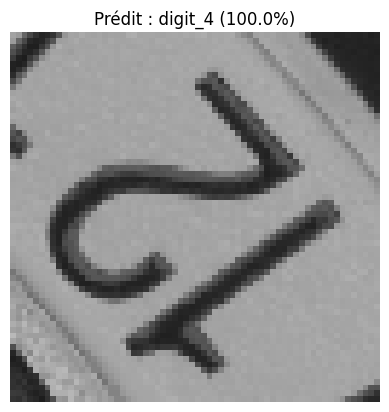

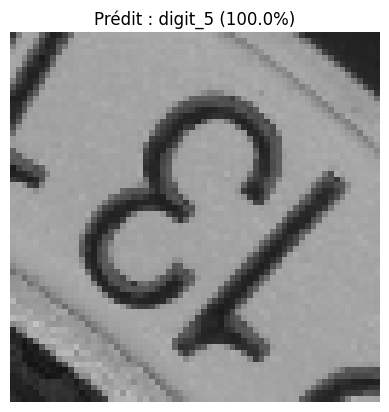

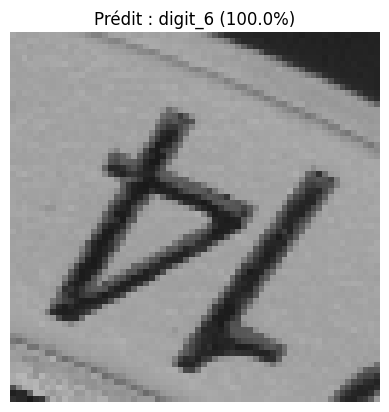

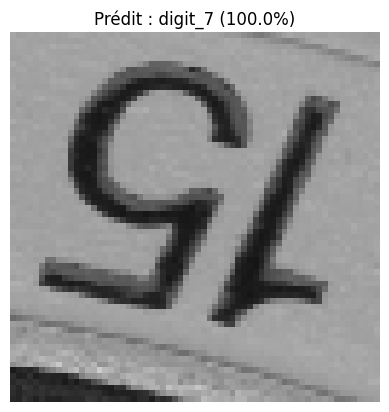

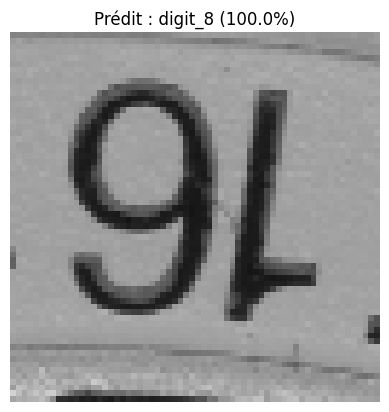

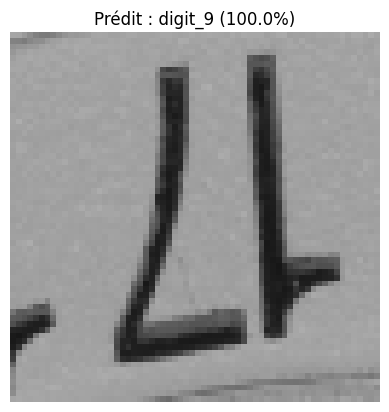

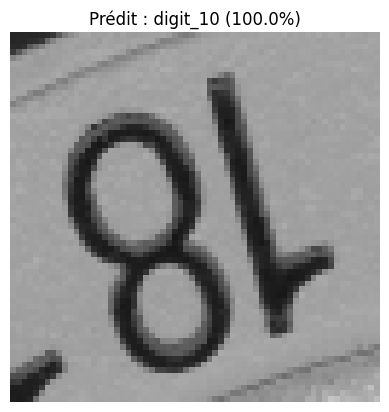

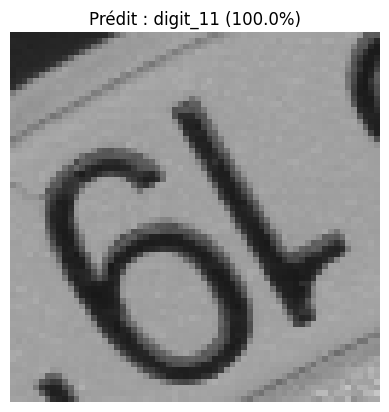

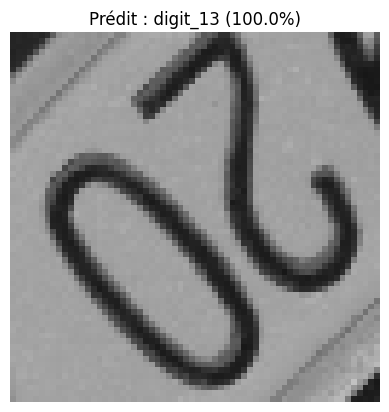

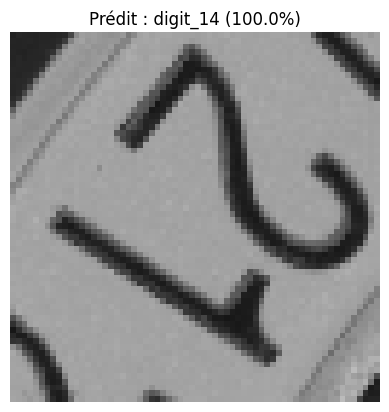

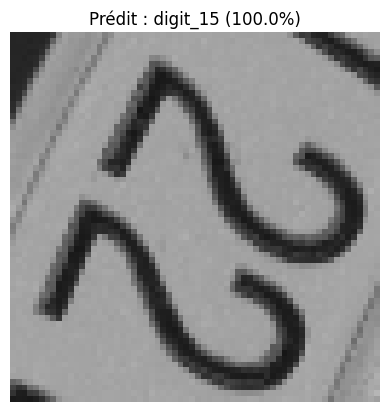

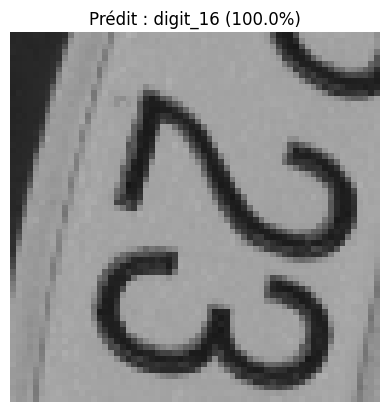

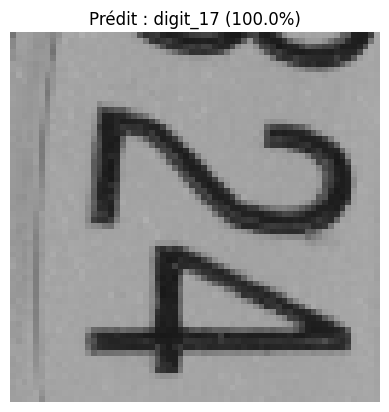

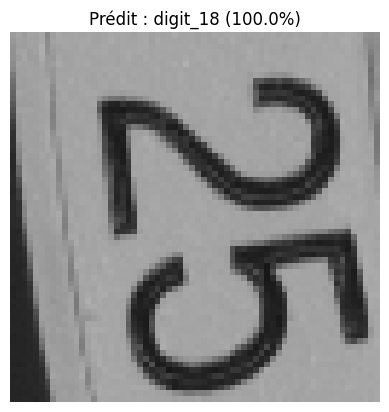

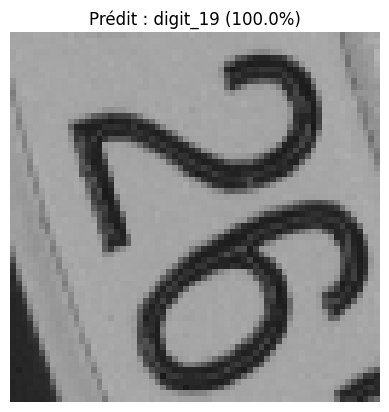

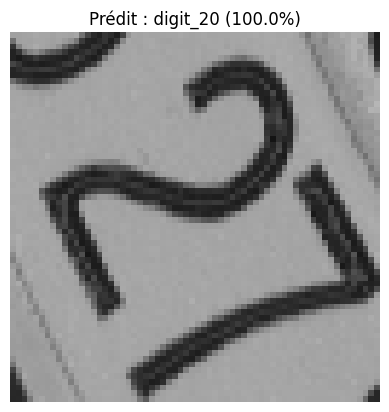

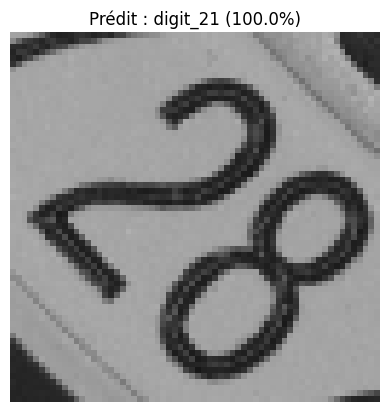

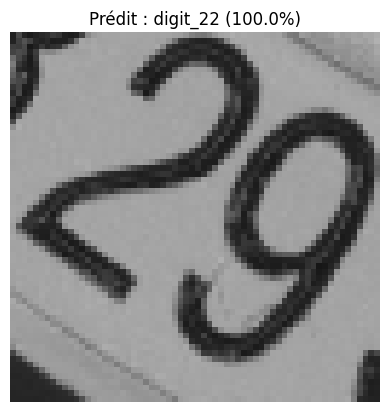

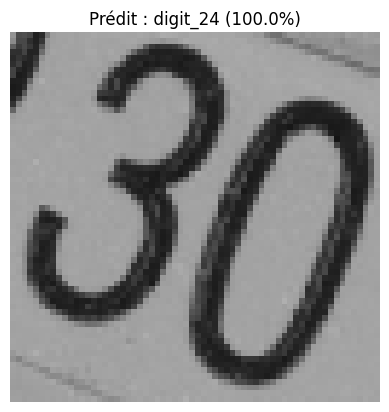

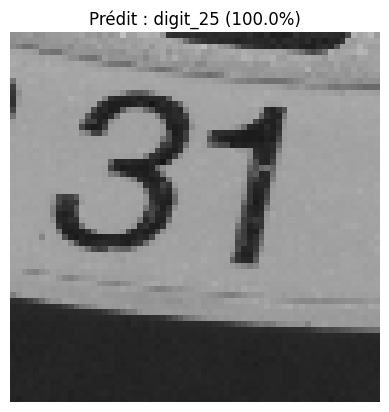


📋 Liste des chiffres prédits :
[1, 12, 23, 26, 27, 28, 29, 30, 31, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25]

📌 Analyse de conformité (chiffres attendus : 1 à 31) :
✅ Conforme : tous les chiffres de 1 à 31 sont présents.


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Charger le modèle
model = load_model("cnn_digits_model.h5")

# Dossier contenant les images à prédire
input_dir = "extracted_rois"

# Lire tous les fichiers image valides
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Taille cible utilisée à l'entraînement
target_size = (64, 64)

# Liste pour stocker les prédictions
predicted_digits = []

# Boucle sur les images
for img_name in image_files:
    img_path = os.path.join(input_dir, img_name)

    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0]) * 100

    predicted_digits.append(predicted_class + 1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Prédit : digit_{predicted_class + 1} ({confidence:.1f}%)")
    plt.axis("off")
    plt.show()

# Analyse de conformité
print("\n📋 Liste des chiffres prédits :")
print(predicted_digits)

# Vérification conformité : de 1 à 31
expected_digits = set(range(1, 31))
predicted_set = set(predicted_digits)
missing_digits = expected_digits - predicted_set

print("\n📌 Analyse de conformité (chiffres attendus : 1 à 31) :")
if not missing_digits:
    print("✅ Conforme : tous les chiffres de 1 à 31 sont présents.")
else:
    print("❌ Non conforme : il manque les chiffres suivants :", sorted(missing_digits))
